In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from iit_tpm import make_tpm, tpm_series
from grn_tpm import iit_tpm_cal

def decimal_to_binary(decimal, min_length=1):
    if min_length == 0:
        return ''
    if decimal == 0:
        return "0" if min_length == 1 else "0".zfill(min_length)
    binary = ""
    while decimal > 0:
        binary = str(decimal % 2) + binary
        decimal = decimal // 2
    # 使用 zfill 确保二进制字符串至少有 min_length 长度
    return binary.zfill(min_length)

def serie_plot(bnet, w, k, steps, seeds=1, name='', leg=False):
    tpm, tpm_v = make_tpm(bnet, w=w, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)   
    colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']
    strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
    for init_state in strs:
        fig, ax = plt.subplots(figsize=(5,2))
        for indx,en in enumerate(["00", "01", "10", "11"]):
            en_state = en
            for seed in range(seeds):
                serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

                # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
                ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx])

        # 设置轴标签
        ax.set_xlabel('Time')
        ax.set_ylabel('System state')

        # 设置y轴的标签
        ax.set_yticks(range(8))
        ax.set_yticklabels(strs)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        if leg:
            plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
        plt.title(name + '_init=' + init_state + '_syn=' + str(round(syn,4)))
        # 显示图形
        plt.show()
        
    return un_sys, un_en, syn

bnet = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('E1', 'A'): 'w1a',
    ('E1', 'B'): 'w1b',
    ('E1', 'C'): 'w1c',
    ('E2', 'A'): 'w2a',
    ('E2', 'B'): 'w2b',
    ('E2', 'C'): 'w2c',
}

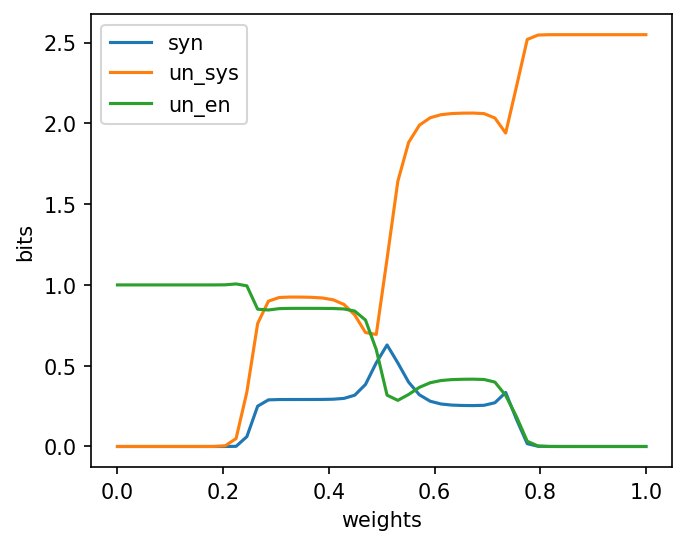

In [7]:

syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 1, 50)
for w in w_axis:
    w2 = 1 - w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_bc': w,
        'w_cb': w,
        'w_cd': w,
        'w_dc': w,
        'w_da': w,
        'w_ad': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w_d': w,
        'w1a': w2,
        'w1b': w2,
        'w1c': w2,
        'w1d': w2,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2,
        'w2d': w2,
        'w3a': w2,
        'w3b': w2,
        'w3c': w2,
        'w3d': w2
    }
    tpm, tpm_v = make_tpm(bnet4, ww, k=30)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=4, en_size=3) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.plot(w_axis, un_en_list, label="un_en")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()

# 不同环境状态下系统演化序列比较

In [10]:
# w1 = {
#     'w1': 0.9,
#     'w2': 0.9,
#     'w3': 0.9,
#     'w4': 0.8,
#     'w5': -0.01,
#     'w6': -0.01
# }

# w2 = {
#     'w1': 0.05,
#     'w2': 0.05,
#     'w3': 0.05,
#     'w4': 0,
#     'w5': -0.9,
#     'w6': -0.9
# }
w=0
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w1a': 0.5,
    'w1b': 0.5,
    'w1c': 0.5,
    'w2a': 0.5,
    'w2b': 0.5,
    'w2c': 0.5
}


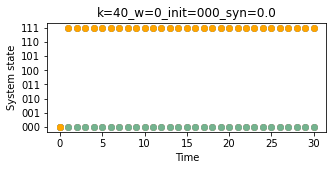

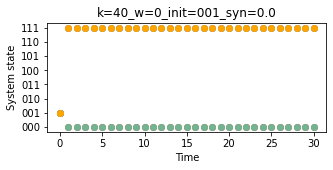

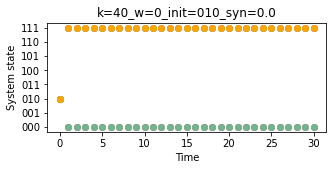

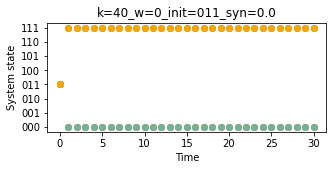

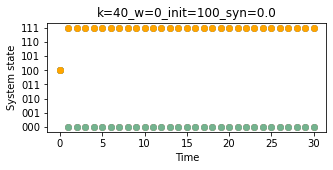

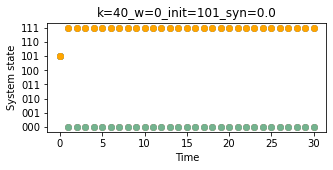

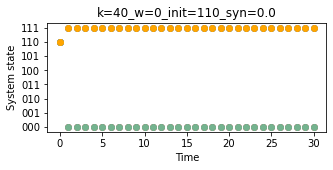

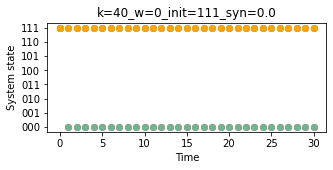

(0.0, 1.0, 1.8422060295964839e-68)

In [10]:
k=40
w = 0
w1 = 1 - w 
w2 = 2 - 2*w
ww = {
        'w_ab': w,
        'w_ba': w,
        'w_ac': w,
        'w_ca': w,
        'w_bc': w,
        'w_cb': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w1a': w1,
        'w1b': w1,
        'w1c': w1,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2
    }
steps = 30
serie_plot(bnet, w=ww, k=k, steps=steps, seeds=1, name='k=40_w='+str(w))

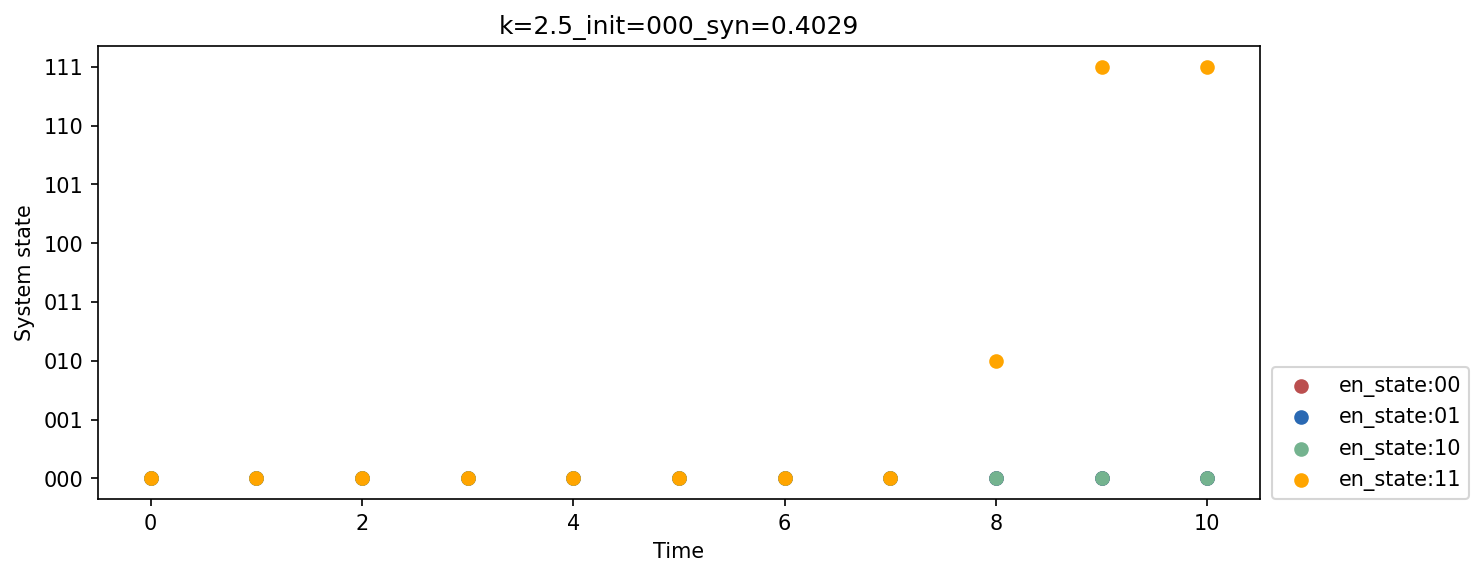

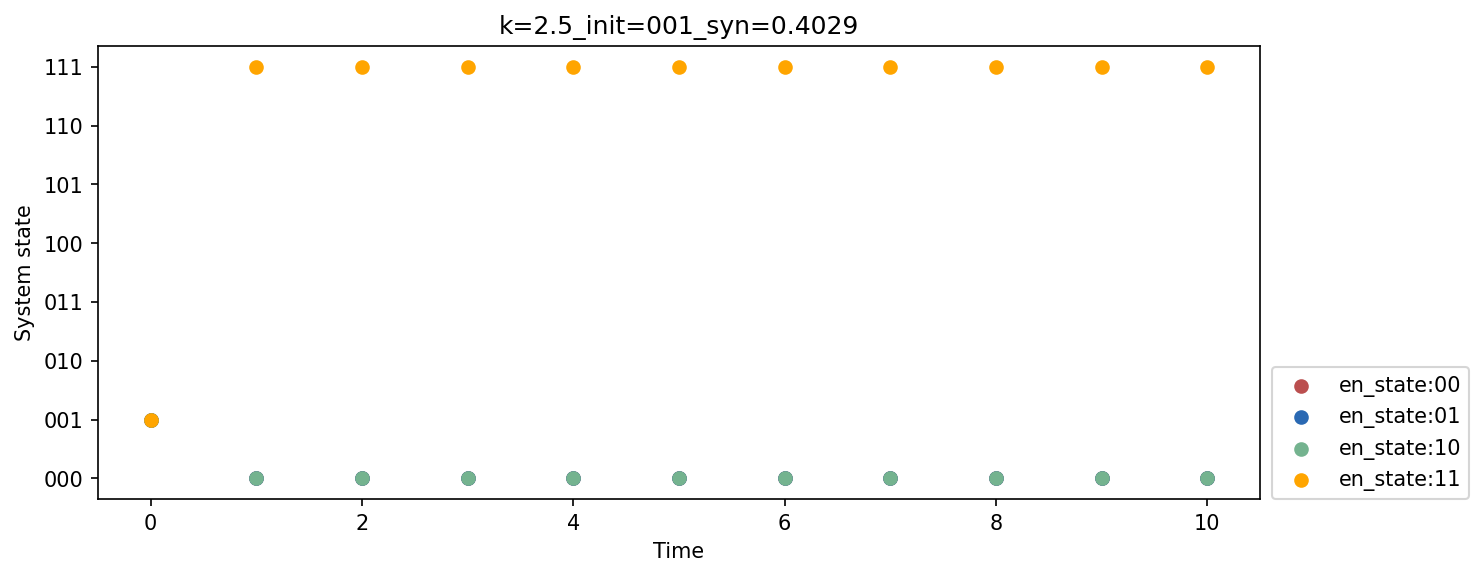

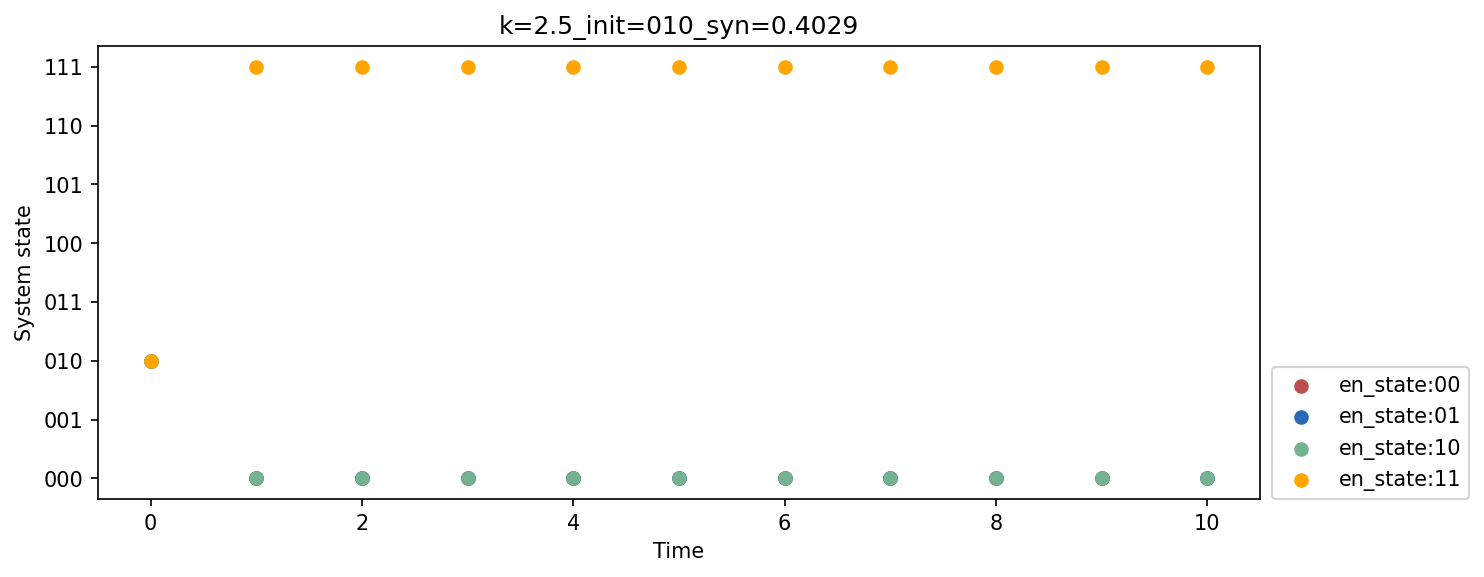

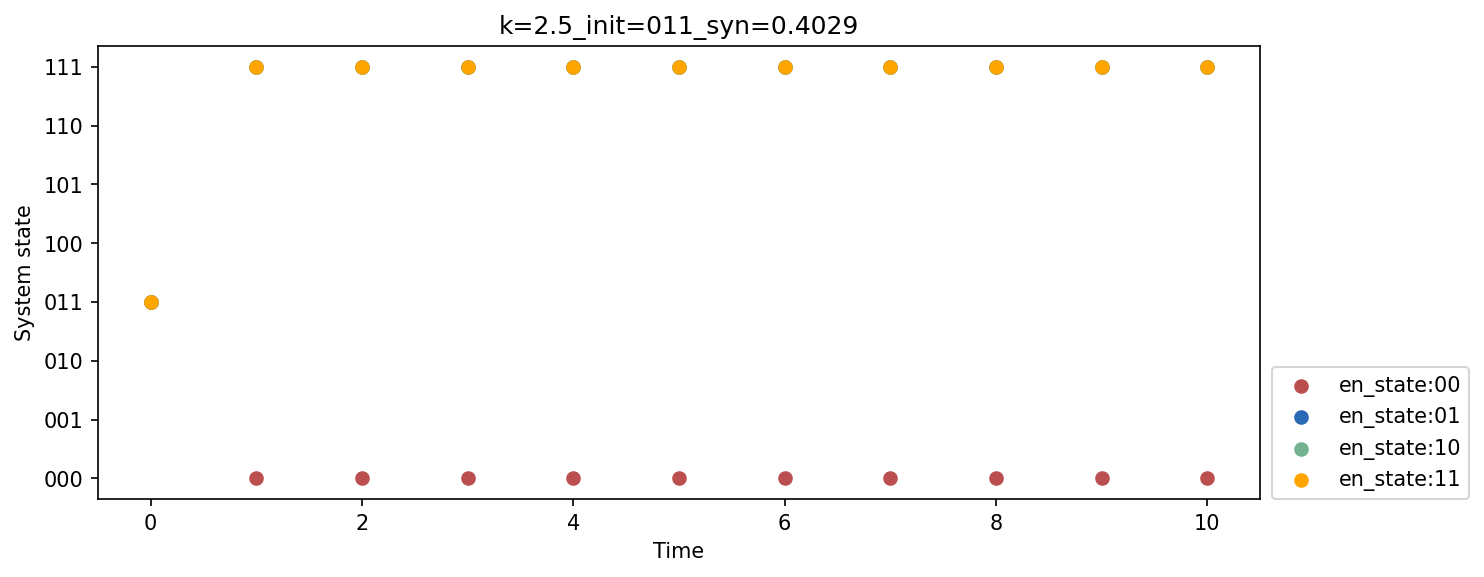

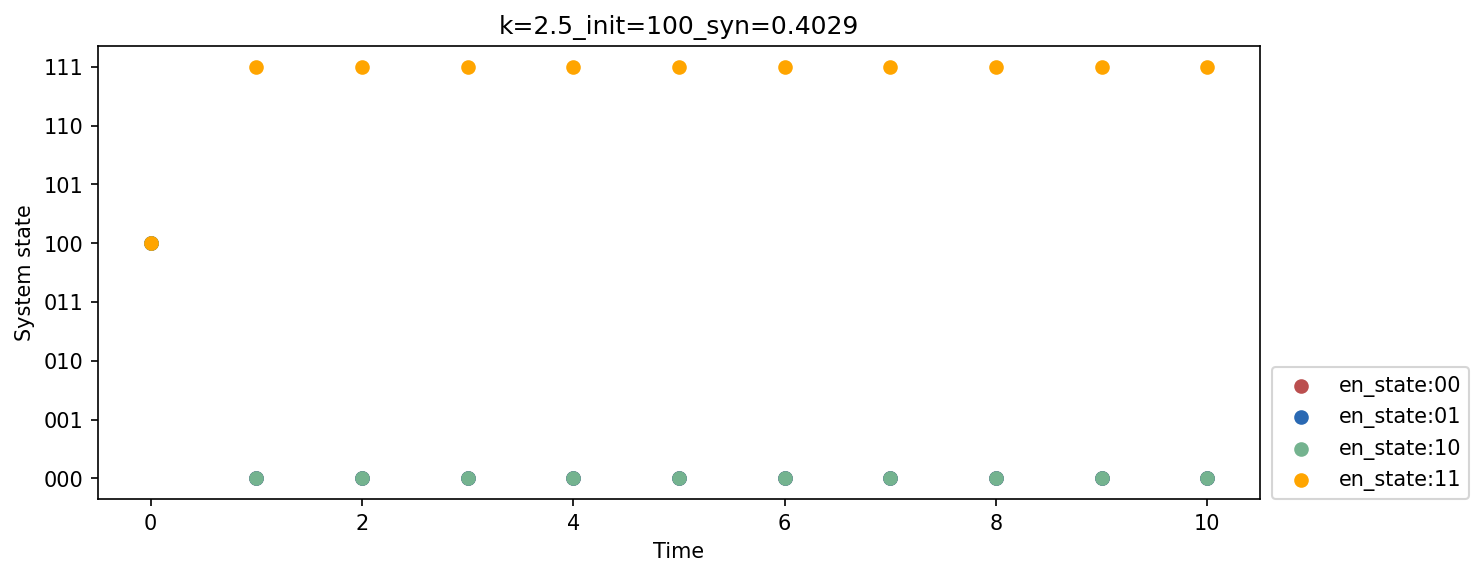

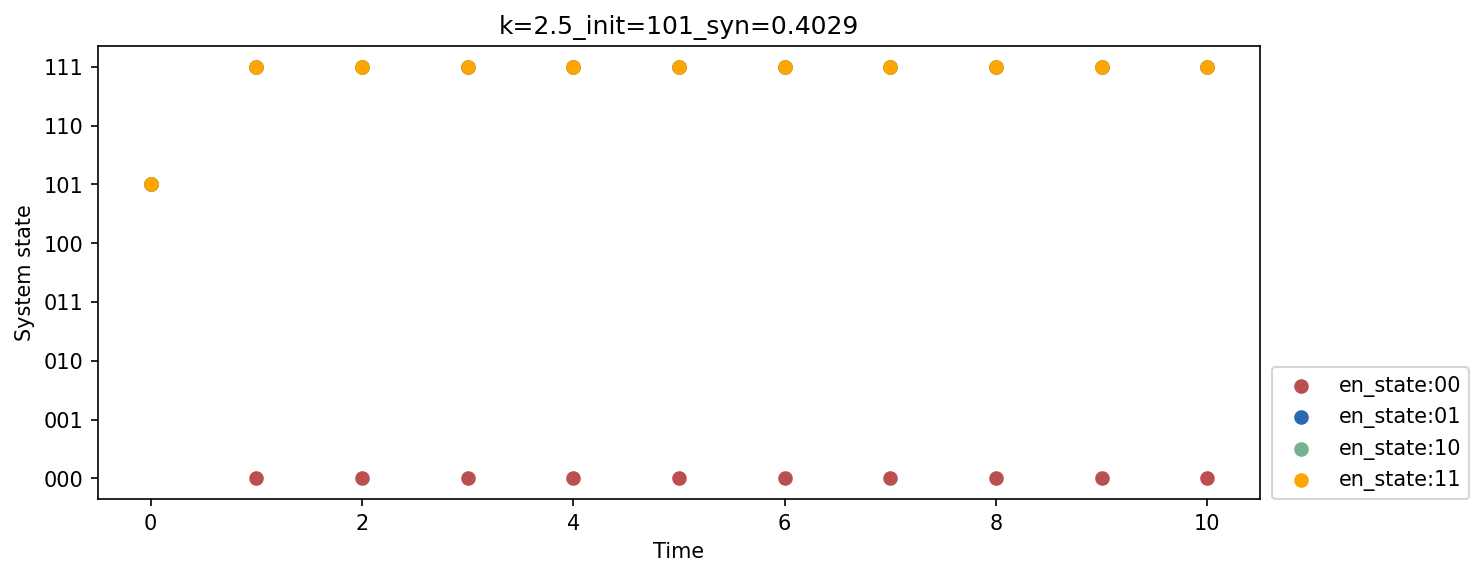

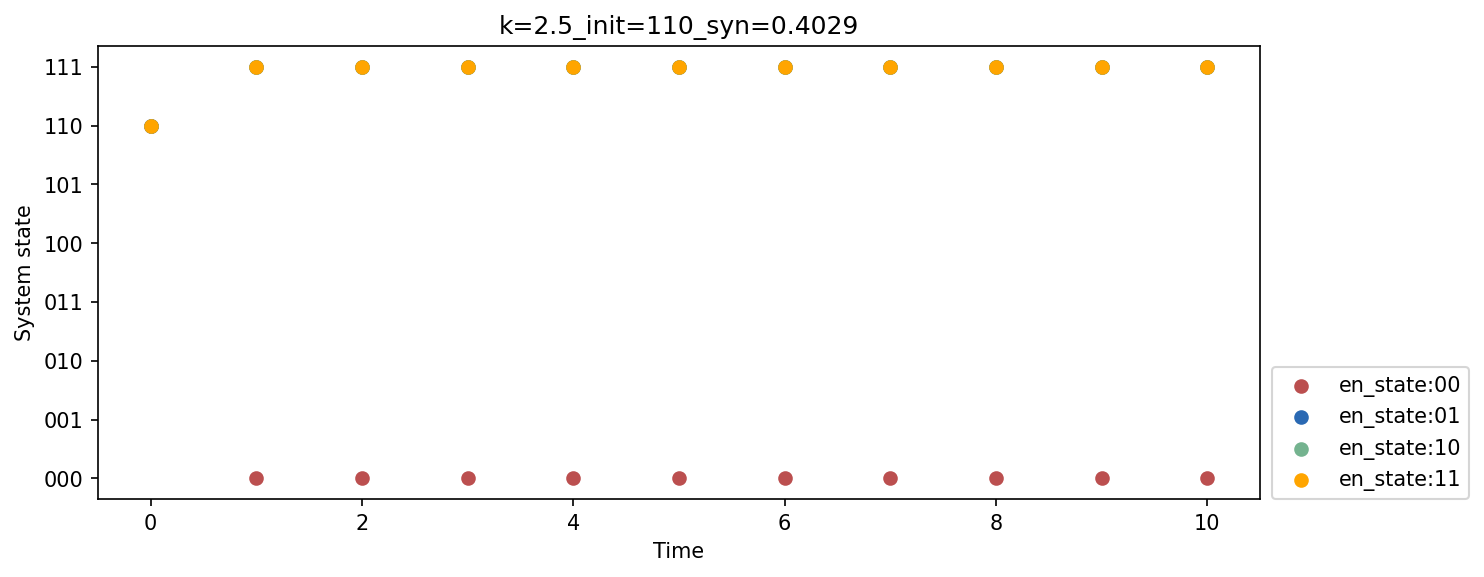

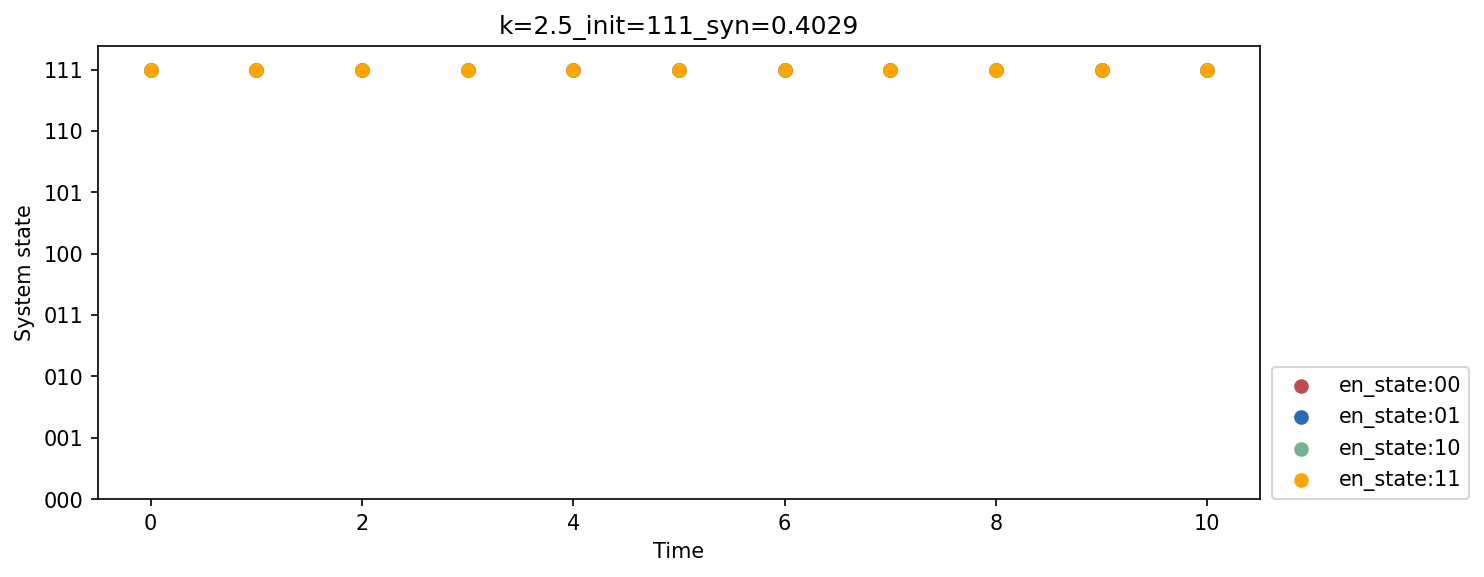

(0.4018526779670124, 0.23445196580260239, 0.40287870471361353)

In [26]:
steps = 10
k=2.5
ww = {
    'w_ab': 1,
    'w_ba': 1,
    'w_ac': 1,
    'w_ca': 1,
    'w_bc': 1,
    'w_cb': 1,
    'w_a': 1,
    'w_b': 1,
    'w_c': 1,
    'w1a': 1,
    'w1b': 1,
    'w1c': 1,
    'w2a': 1,
    'w2b': 1,
    'w2c': 1
}
serie_plot(bnet, w=ww, k=k, steps=steps, seeds=1, name='k='+str(k))


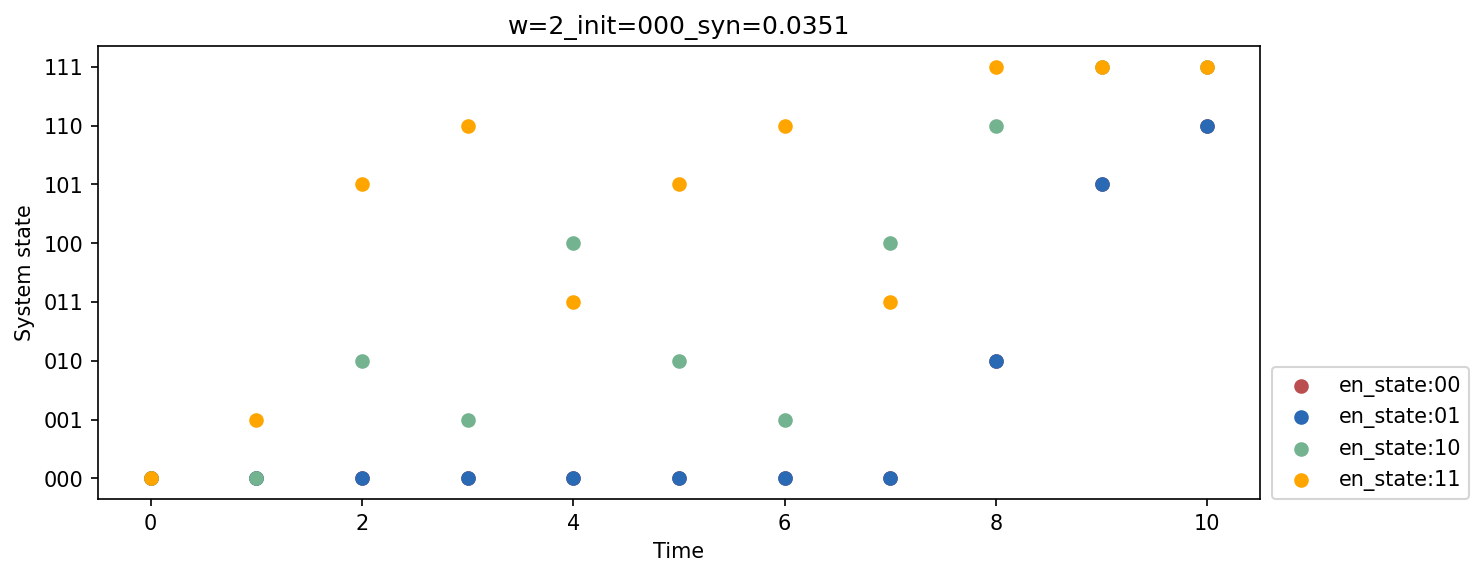

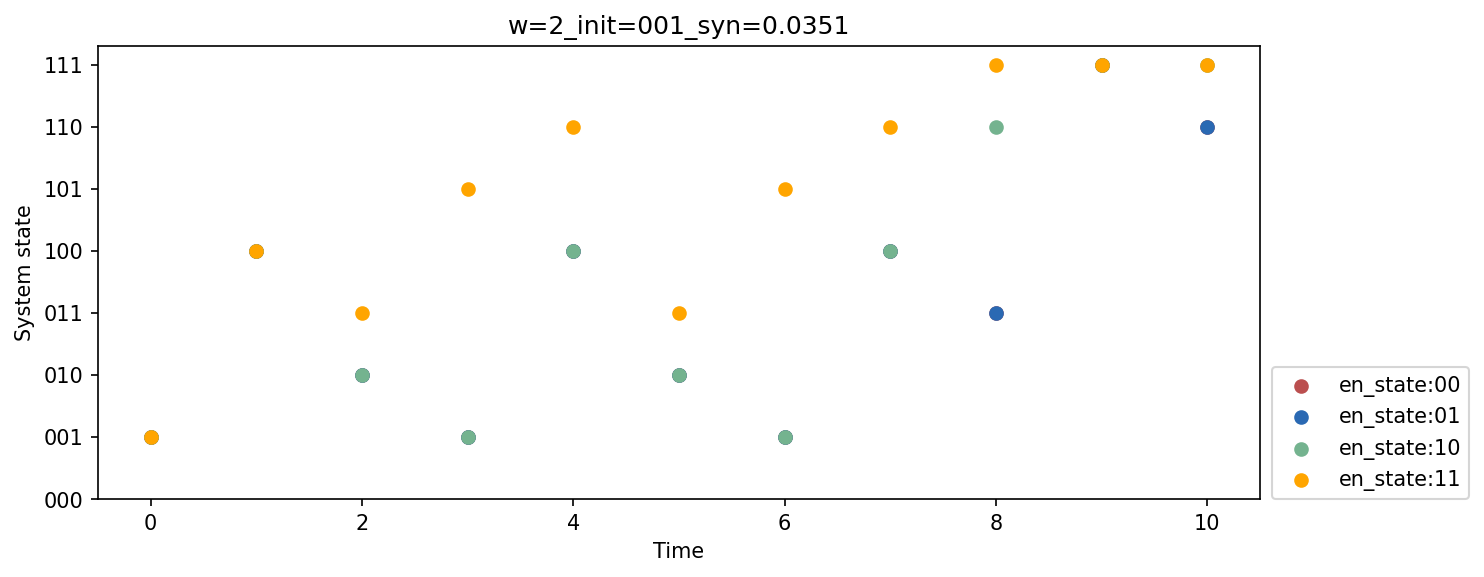

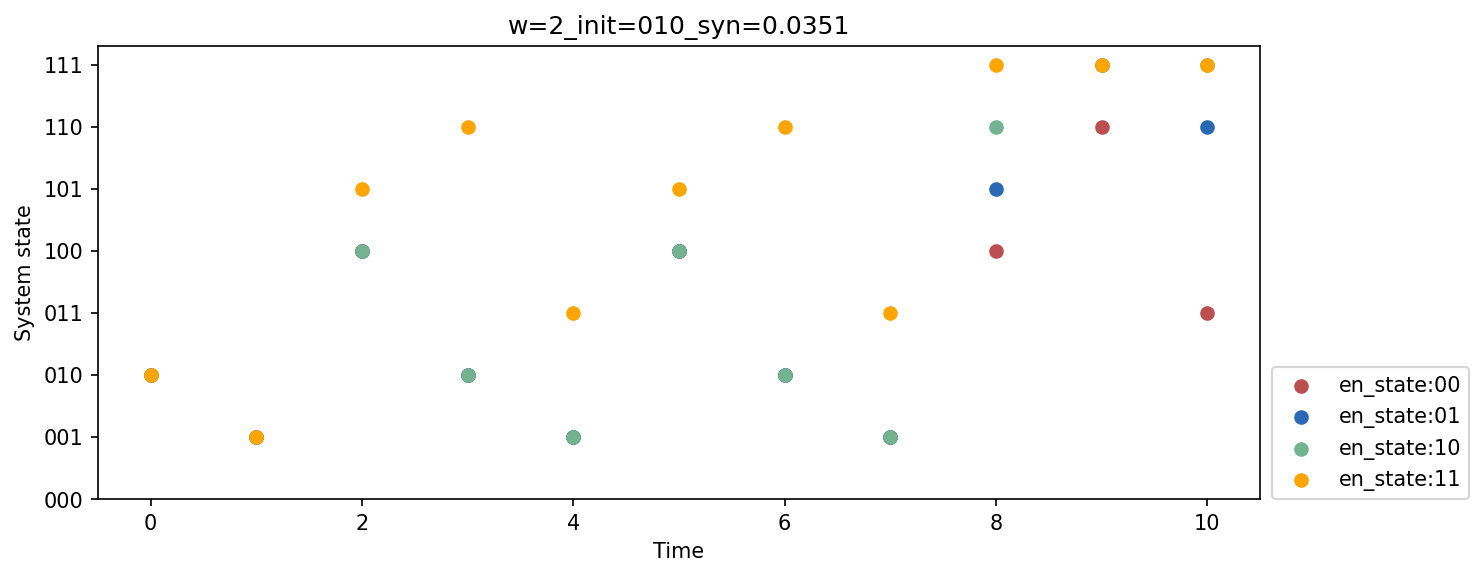

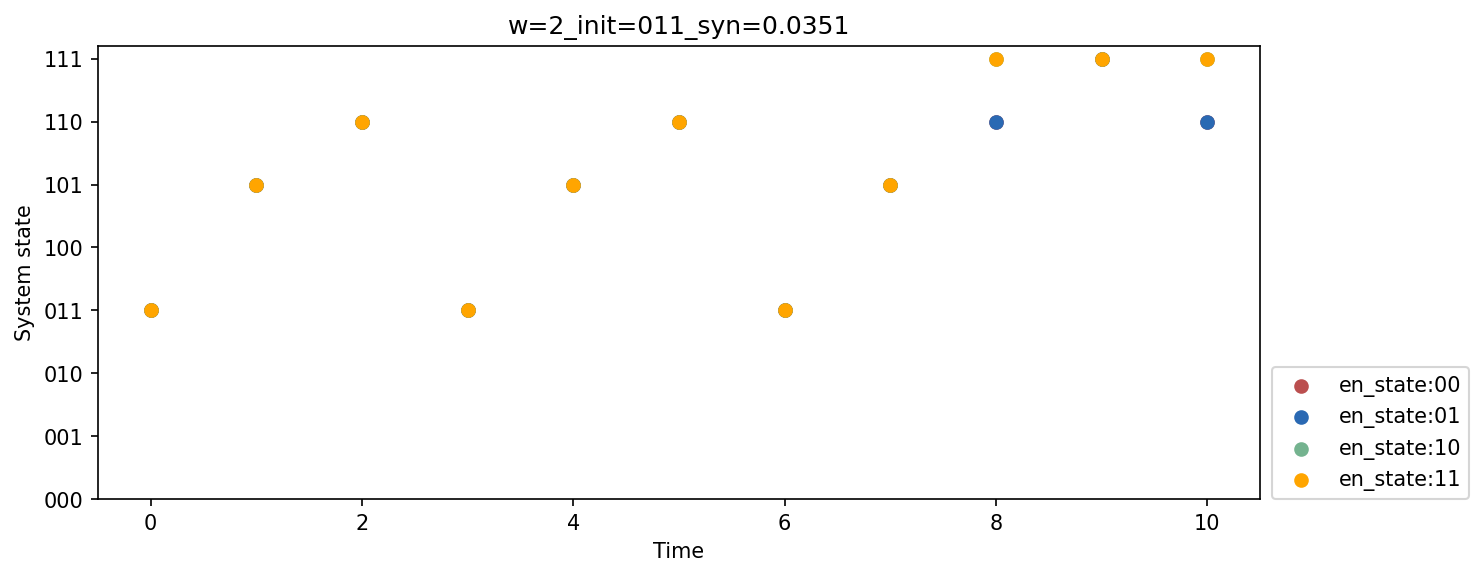

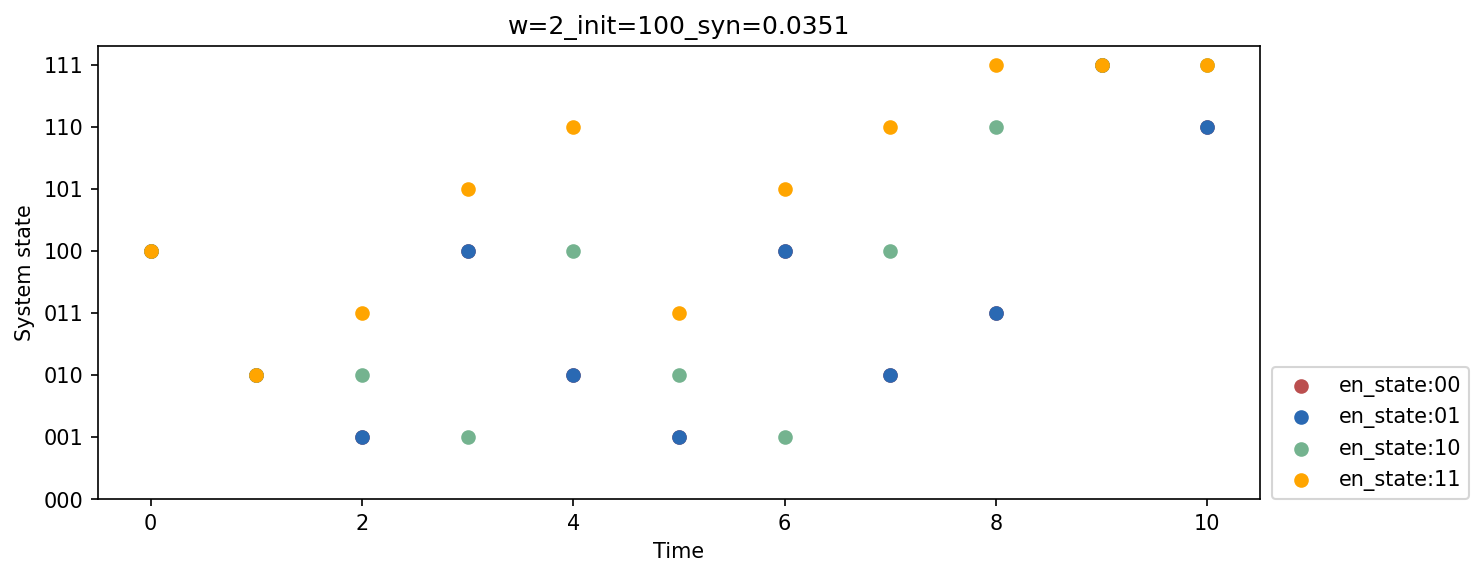

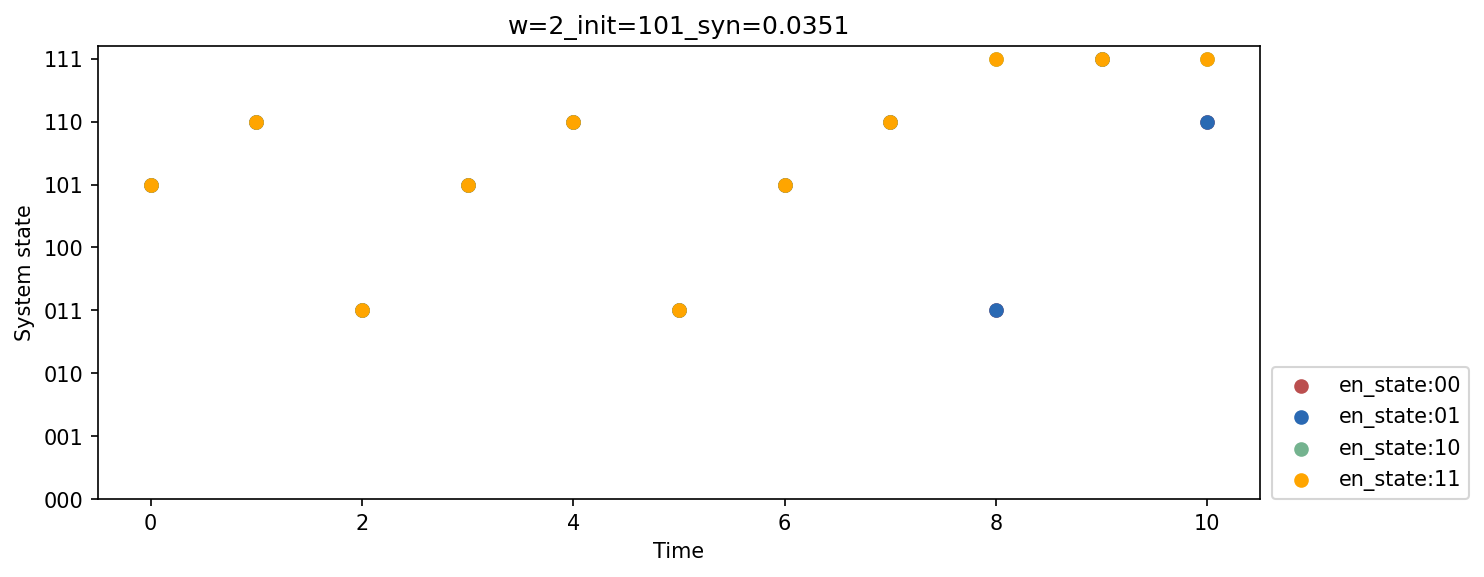

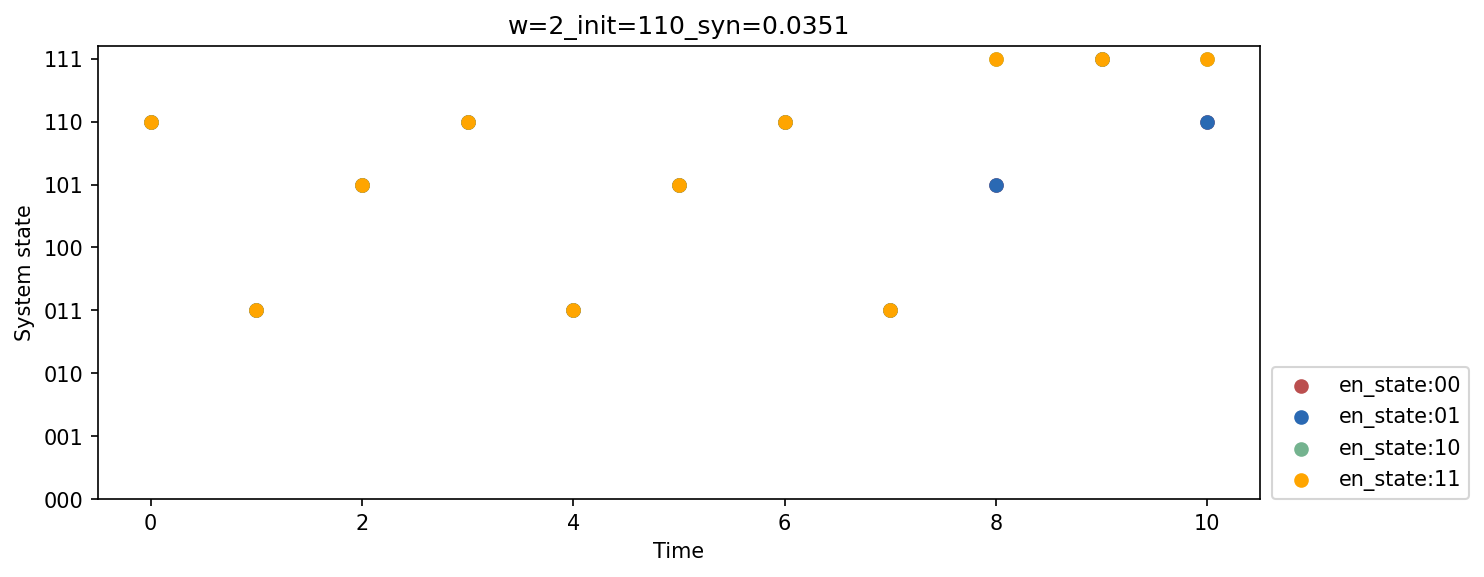

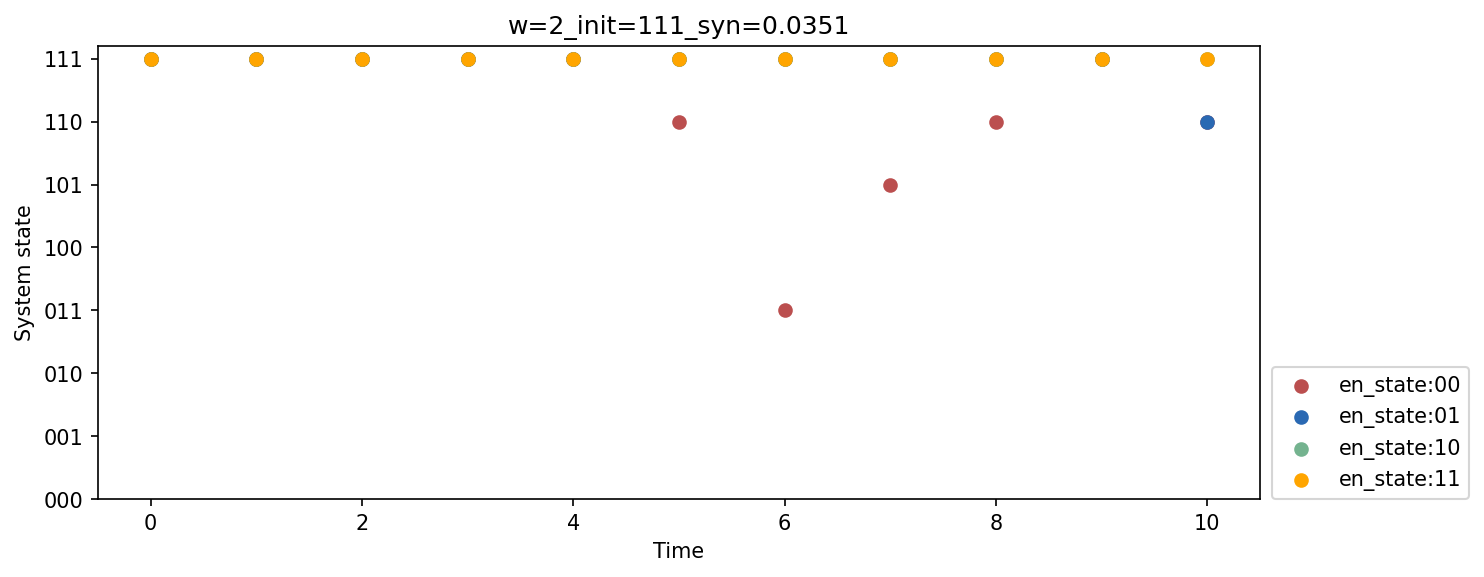

(1.3235631629332094, 0.028785961446413443, 0.03505210211167009)

In [31]:
steps = 10
k=1
w=2
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w1a': 0.5,
    'w1b': 0.5,
    'w1c': 0.5,
    'w2a': 0.2,
    'w2b': 0.2,
    'w2c': 0.2
}
serie_plot(bnet, w=ww, k=k, steps=steps, seeds=1, name='w='+str(w))

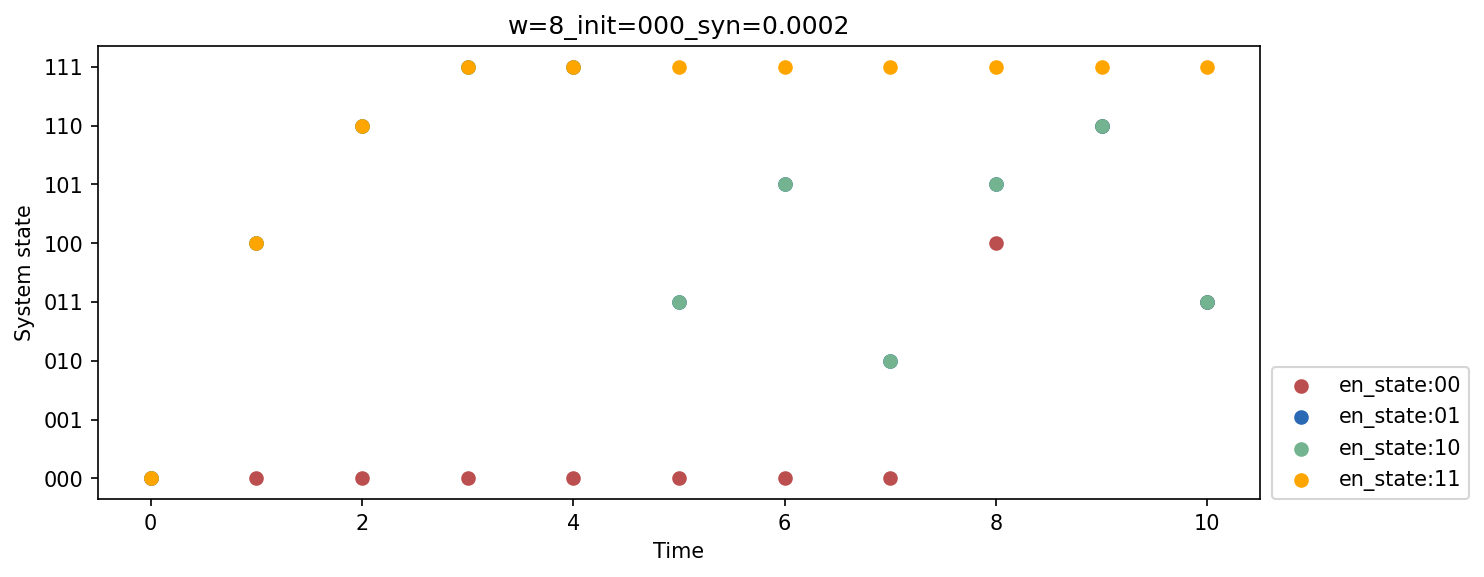

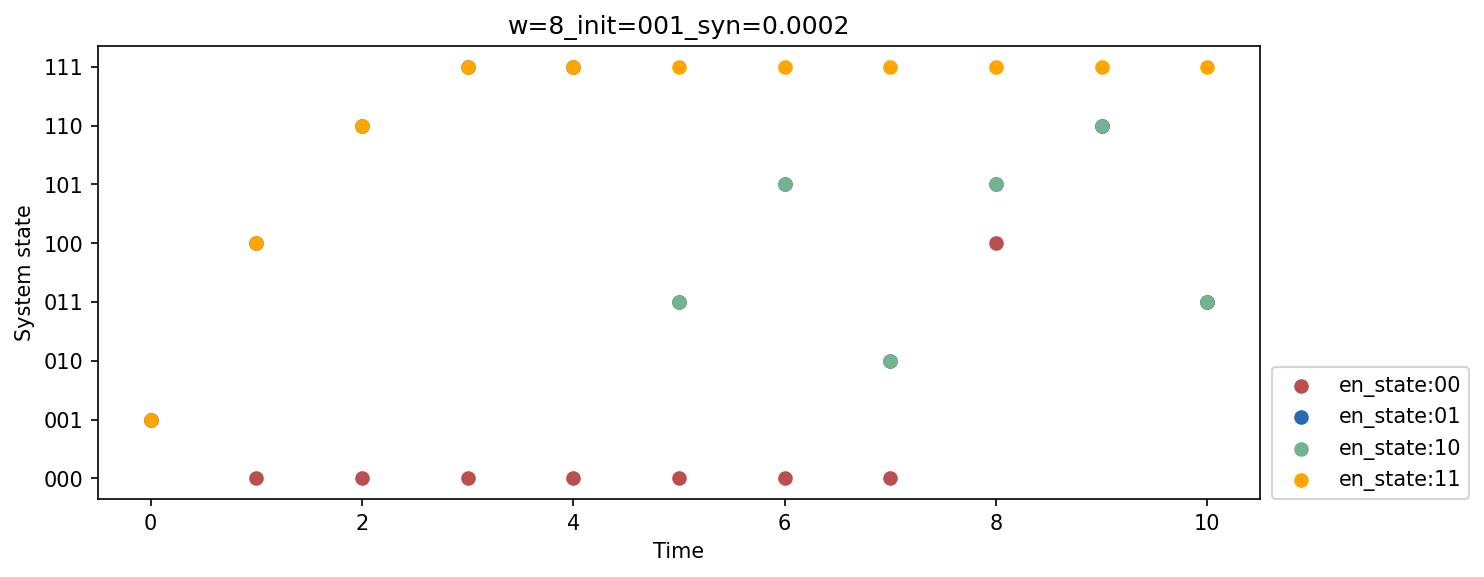

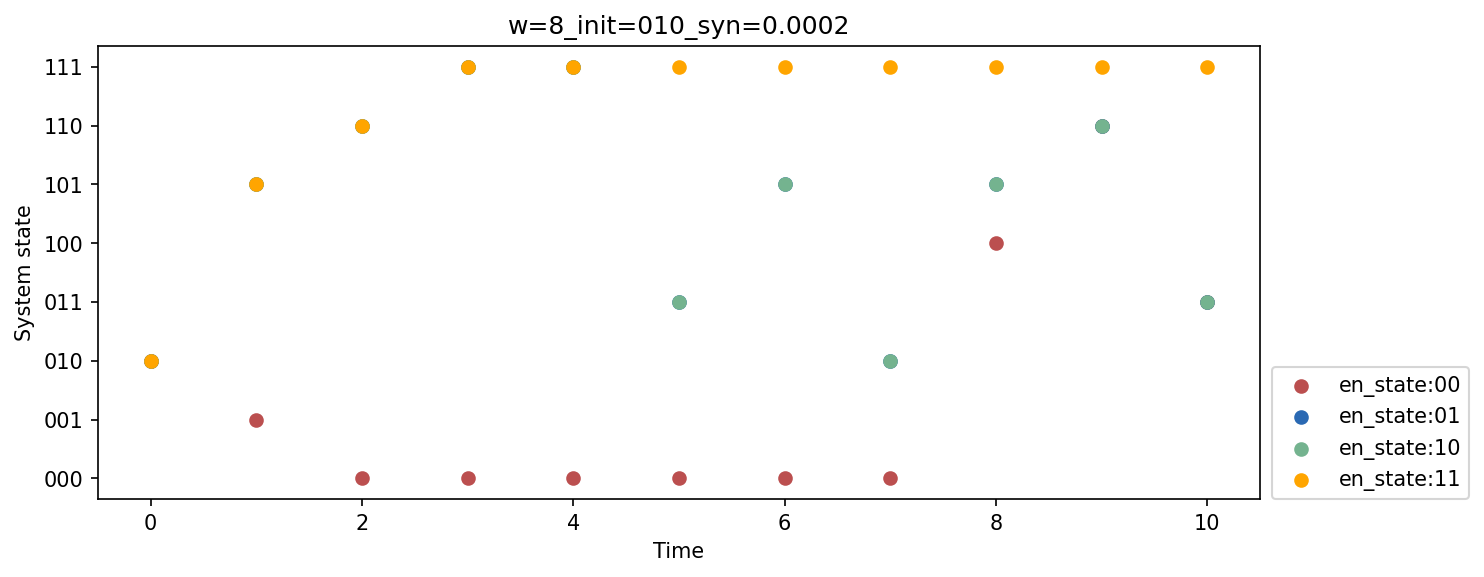

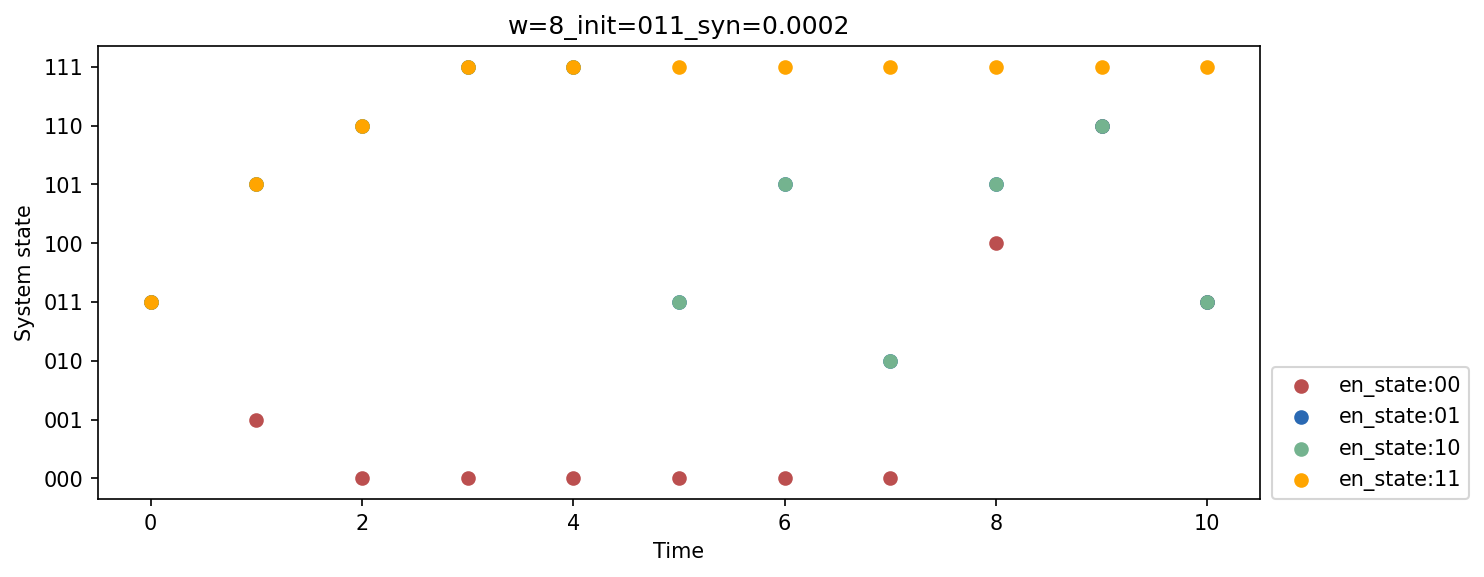

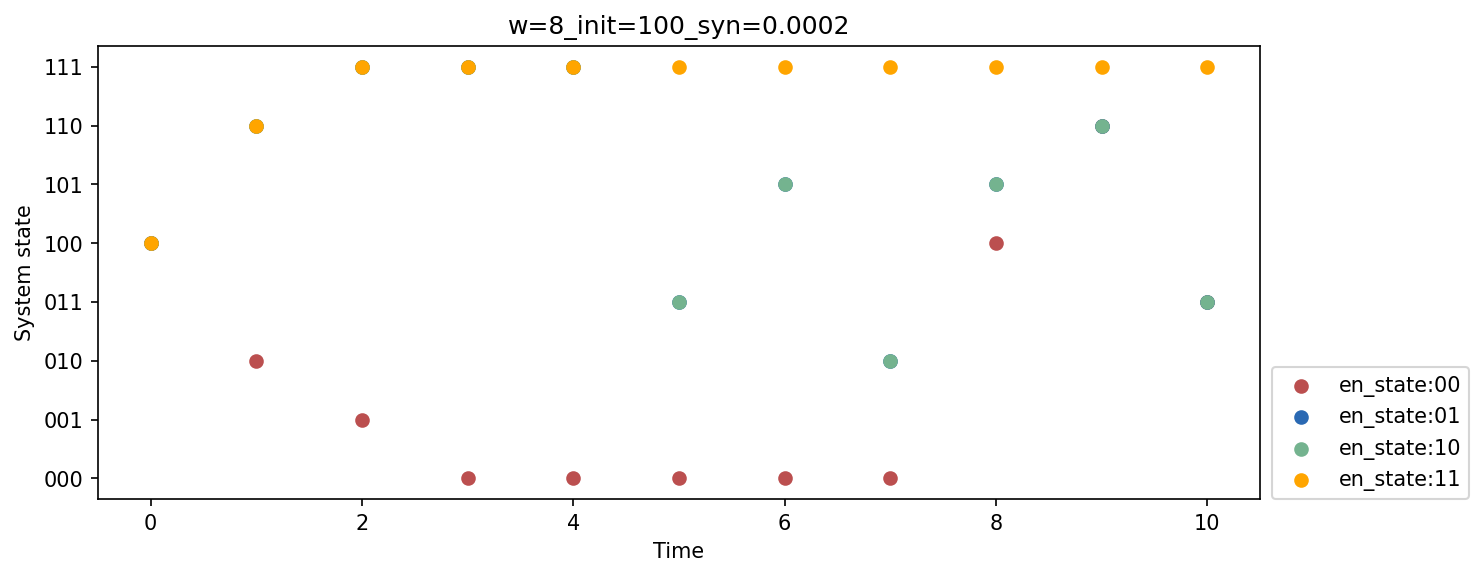

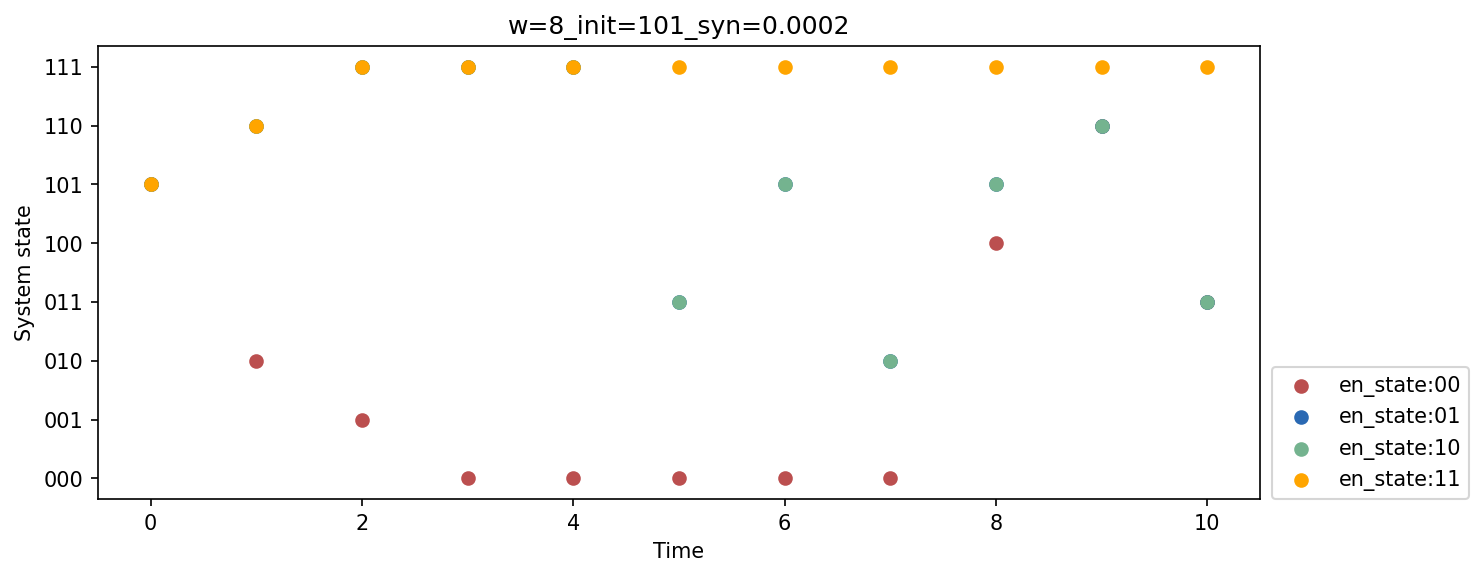

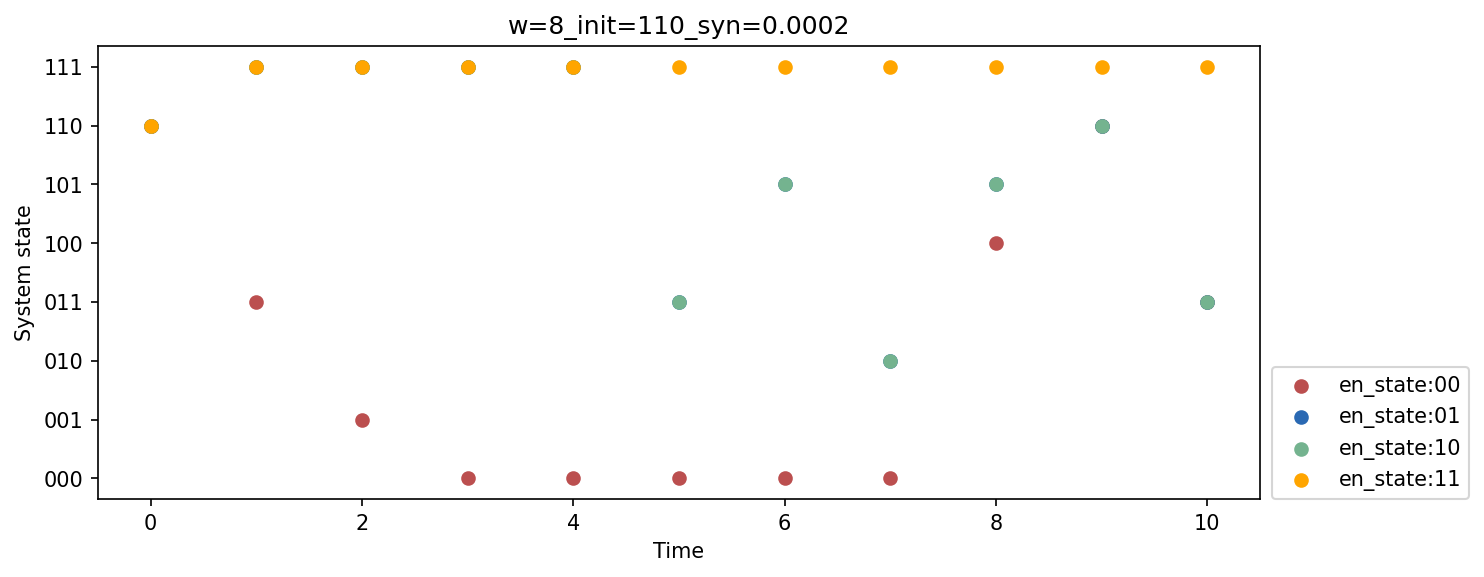

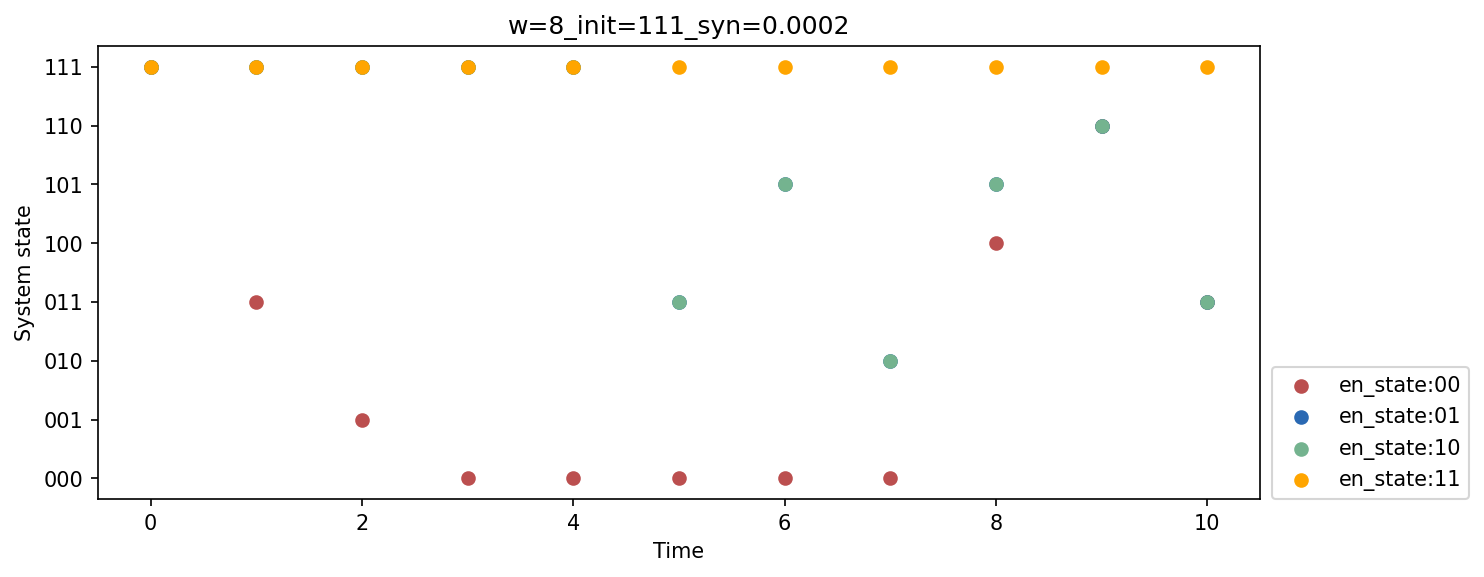

(1.9892531708828565, 0.08002963074942497, 0.00024414380528559043)

In [34]:
steps = 10
k=1
w=8
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': 0,
    'w_bc': w,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w1a': 0.5,
    'w1b': 0.5,
    'w1c': 0.5,
    'w2a': 0.5,
    'w2b': 0.5,
    'w2c': 0.5
}
serie_plot(bnet, w=ww, k=k, steps=steps, seeds=1, name='w=8')

# 最佳噪音实验复现

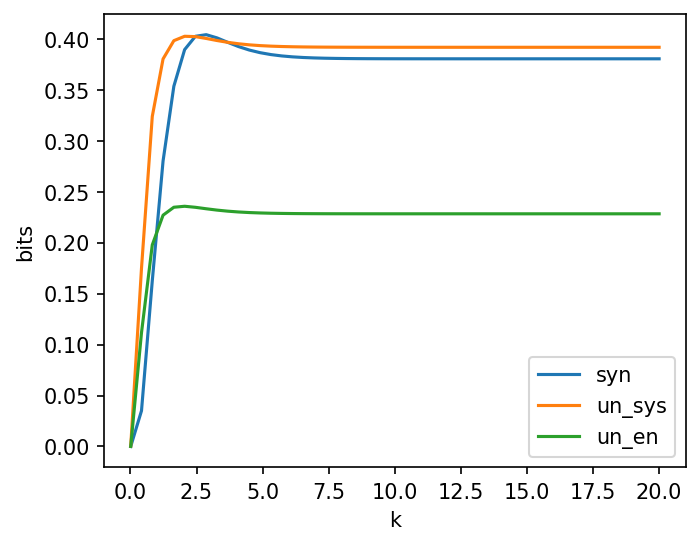

In [19]:
ww = {
    'w_ab': 1,
    'w_ba': 1,
    'w_ac': 1,
    'w_ca': 1,
    'w_bc': 1,
    'w_cb': 1,
    'w_a': 1,
    'w_b': 1,
    'w_c': 1,
    'w1a': 1,
    'w1b': 1,
    'w1c': 1,
    'w2a': 1,
    'w2b': 1,
    'w2c': 1
}


syn_list = []
un_sys_list = []
un_en_list = []
k_axis = np.linspace(0.01, 20, 50)
for k in k_axis:
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(k_axis, syn_list, label='syn')
plt.plot(k_axis, un_sys_list, label="un_sys")
plt.plot(k_axis, un_en_list, label="un_en")
plt.xlabel('k')
plt.ylabel('bits')
plt.legend()

# plt.figure(figsize=(5,4),dpi=150)
# plt.plot(k_axis, un_sys_list)
# plt.xlabel('k')
# plt.ylabel('un')
#un_sys, un_en, syn = serie_plot(bnet, w, k, steps, seeds=1)

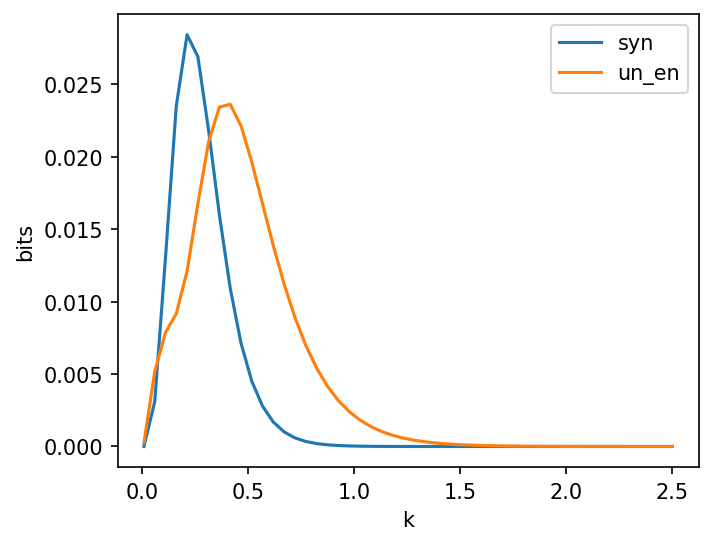

In [48]:
ww = {
    'w_ab': 9,
    'w_ba': 9,
    'w_ac': 9,
    'w_ca': 9,
    'w_bc': 9,
    'w_cb': 9,
    'w_a': 9,
    'w_b': 9,
    'w_c': 9,
    'w1a': 2,
    'w1b': 2,
    'w1c': 2,
    'w2a': 1,
    'w2b': 1,
    'w2c': 1
}


syn_list = []
un_sys_list = []
un_en_list = []
k_axis = np.linspace(0.01, 2.5, 50)
for k in k_axis:
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(k_axis, syn_list, label='syn')
#plt.plot(k_axis, un_sys_list, label="un_sys")
plt.plot(k_axis, un_en_list, label="un_en")
plt.xlabel('k')
plt.ylabel('bits')
plt.legend()

/home/yuanbing/data/test/ymz_nis/Local-EI-project/exp/bool_network/grn/iit_tpm.py:75: RuntimeWarning: overflow encountered in exp
  states_to_units_pos_tpm = 1. / (1. + np.exp(-k * s_values @ wm))


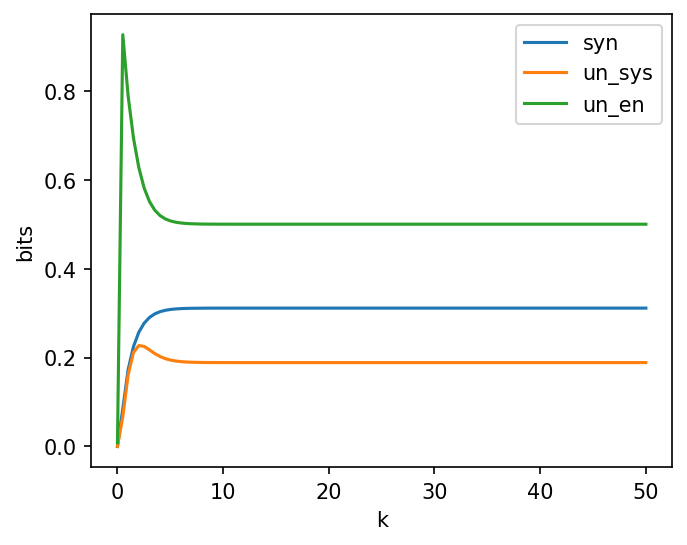

In [52]:
ww = {
    'w_ab': 1,
    'w_ba': 1,
    'w_ac': 1,
    'w_ca': 1,
    'w_bc': 1,
    'w_cb': 1,
    'w_a': 1,
    'w_b': 1,
    'w_c': 1,
    'w1a': 9,
    'w1b': 9,
    'w1c': 9,
    'w2a': 9,
    'w2b': 9,
    'w2c': 9
}


syn_list = []
un_sys_list = []
un_en_list = []
k_axis = np.linspace(0.01, 50, 100)
for k in k_axis:
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(k_axis, syn_list, label='syn')
plt.plot(k_axis, un_sys_list, label="un_sys")
plt.plot(k_axis, un_en_list, label="un_en")
plt.xlabel('k')
plt.ylabel('bits')
plt.legend()

# 不同系统结构应对环境变化

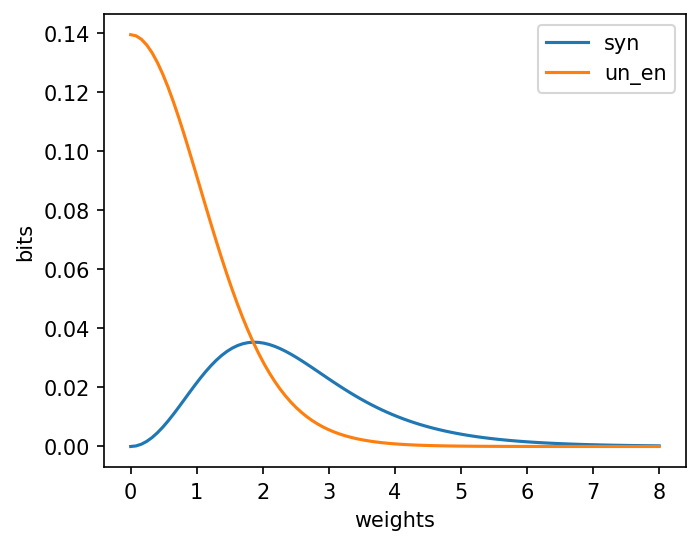

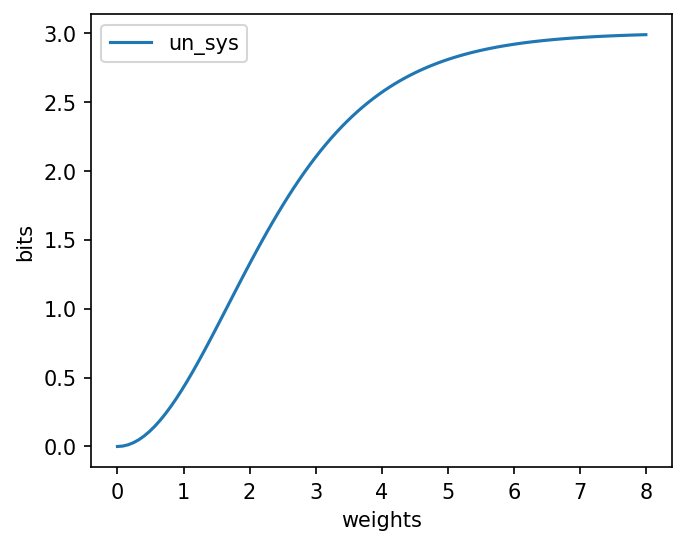

In [28]:
steps = 10
k=1
w=2
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w1a': 0.5,
    'w1b': 0.5,
    'w1c': 0.5,
    'w2a': 0.2,
    'w2b': 0.2,
    'w2c': 0.2
}



syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 8, 100)
for w in w_axis:
    ww['w_ab'] = w
    ww['w_bc'] = w
    ww['w_ca'] = w
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_en_list, label="un_en")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()

plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()
#un_sys, un_en, syn = serie_plot(bnet, w, k, steps, seeds=1)

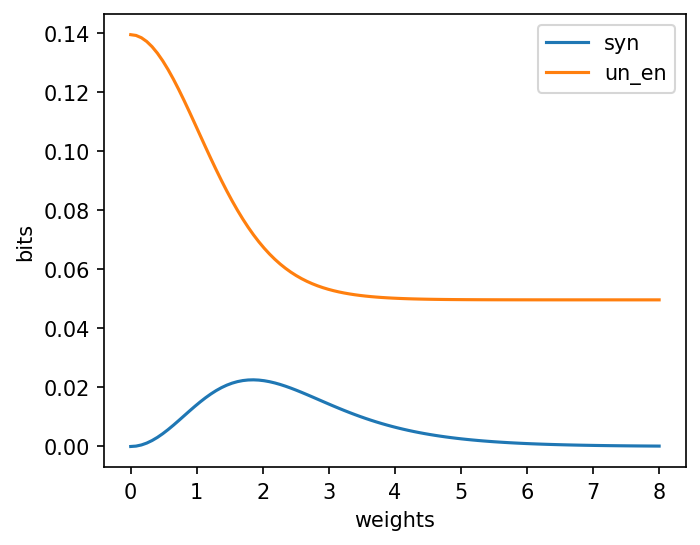

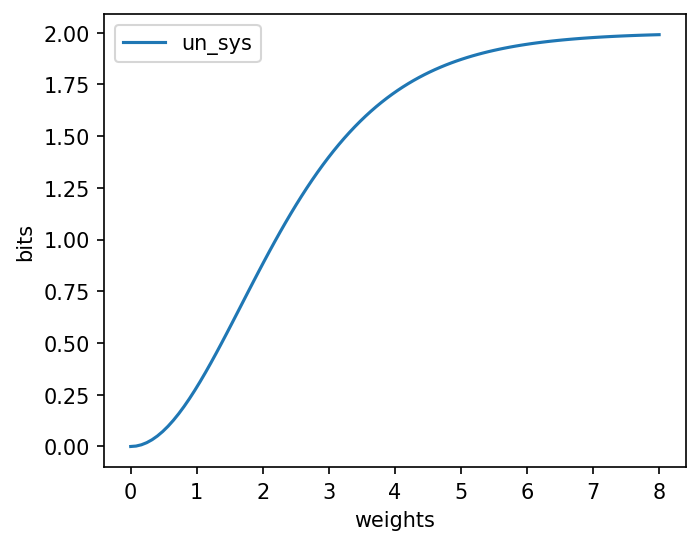

In [33]:
steps = 10
k=1
ww = {
    'w_ab': 0,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': 0,
    'w_bc': 0,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w1a': 0.5,
    'w1b': 0.5,
    'w1c': 0.5,
    'w2a': 0.2,
    'w2b': 0.2,
    'w2c': 0.2
}



syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 8, 100)
for w in w_axis:
    ww['w_ab'] = w
    ww['w_bc'] = w
#     ww['w_c'] = w
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_en_list, label="un_en")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()

plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()

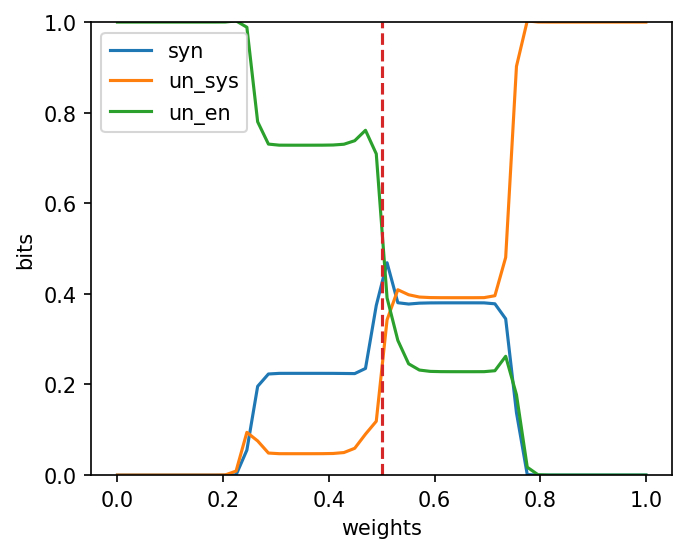

In [173]:
k=40
syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 1, 50)
for w in w_axis:
    w1 = 1 - w
    w2 = 2 - 2*w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_ac': w,
        'w_ca': w,
        'w_bc': w,
        'w_cb': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w1a': w1,
        'w1b': w1,
        'w1c': w1,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2
    }
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.plot(w_axis, un_en_list, label="un_en")
plt.plot([0.5,0.5], [0,1], linestyle='--')
plt.xlabel('weights')
plt.ylabel('bits')
plt.ylim([0,1])
plt.legend()

# plt.figure(figsize=(5,4),dpi=150)
# plt.plot(w_axis, un_sys_list, label="un_sys")
# plt.xlabel('weights')
# plt.ylabel('bits')
# plt.legend()

# 同时调节k和w

In [139]:
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
k_axis = np.linspace(0, 16, n)
for w_id,w in enumerate(w_axis):
    w1 = 1 - w
    w2 = 2 - 2*w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_ac': w,
        'w_ca': w,
        'w_bc': w,
        'w_cb': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w1a': w1,
        'w1b': w1,
        'w1c': w1,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet, ww, k=k)
        un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en



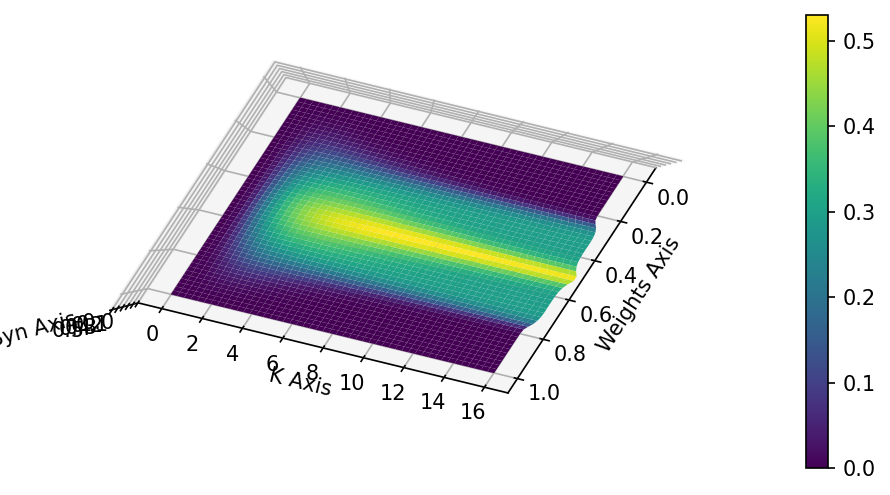

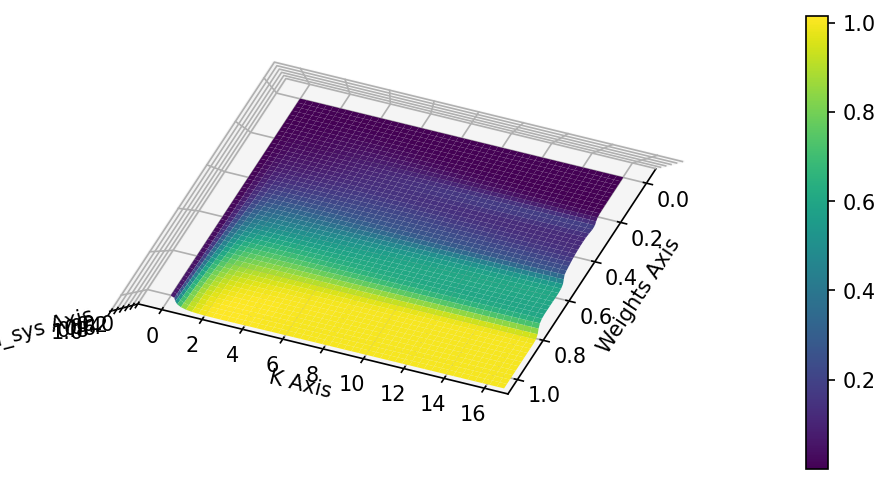

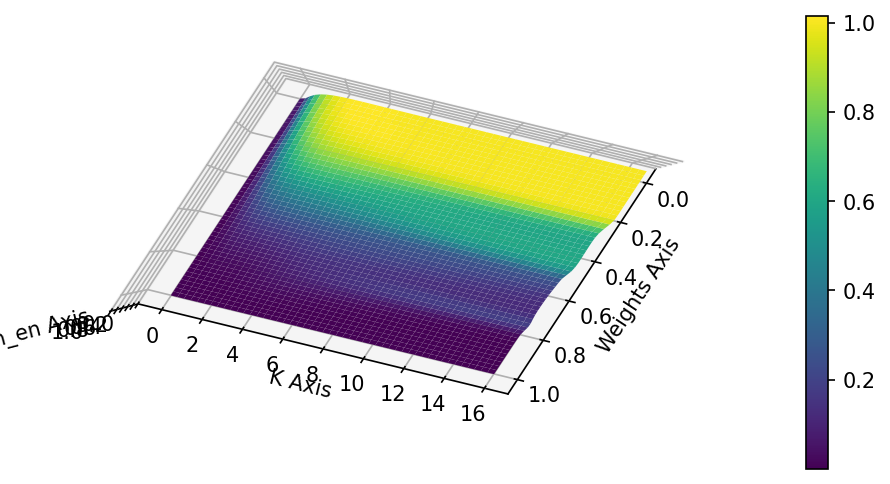

In [145]:
def plot_3d(axis1, axis2, measure, name=''):
    # 创建一个新的figure
    fig = plt.figure(figsize=(8,4), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    data = measure
    X, Y = np.meshgrid(axis1, axis2)
    Z = data
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    fig.colorbar(surf)
    ax.set_xlabel('Weights Axis')
    ax.set_ylabel('K Axis')
    ax.set_zlabel(name + ' Axis')
    ax.view_init(elev=90, azim=20)
    plt.show()
    return

plot_3d(w_axis, k_axis, syn_arr, "Syn")
plot_3d(w_axis, k_axis, un_sys_arr, "Un_sys")
plot_3d(w_axis, k_axis, un_en_arr, "Un_en")

# 系统与环境规模的变化

In [2]:
bnet5 = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('A', 'D'): 'w_ad',
    ('D', 'A'): 'w_da',
    ('A', 'E'): 'w_ae',
    ('E', 'A'): 'w_ea',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('B', 'D'): 'w_bd',
    ('D', 'B'): 'w_db',
    ('B', 'E'): 'w_be',
    ('E', 'B'): 'w_eb',
    ('C', 'D'): 'w_cd',
    ('D', 'C'): 'w_dc',
    ('C', 'E'): 'w_ce',
    ('E', 'C'): 'w_ec',
    ('D', 'E'): 'w_de',
    ('E', 'D'): 'w_ed',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('D', 'D'): 'w_d',
    ('E', 'E'): 'w_e',
    ('Q1', 'A'): 'w1a',
    ('Q1', 'B'): 'w1b',
    ('Q1', 'C'): 'w1c',
    ('Q1', 'D'): 'w1d',
    ('Q1', 'E'): 'w1e',
    ('Q2', 'A'): 'w2a',
    ('Q2', 'B'): 'w2b',
    ('Q2', 'C'): 'w2c',
    ('Q2', 'D'): 'w2d',
    ('Q2', 'E'): 'w2e',
    ('Q3', 'A'): 'w3a',
    ('Q3', 'B'): 'w3b',
    ('Q3', 'C'): 'w3c',
    ('Q3', 'D'): 'w3d',
    ('Q3', 'E'): 'w3e',
}

bnet4 = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('A', 'D'): 'w_ad',
    ('D', 'A'): 'w_da',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('B', 'D'): 'w_bd',
    ('D', 'B'): 'w_db',
    ('C', 'D'): 'w_cd',
    ('D', 'C'): 'w_dc',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('D', 'D'): 'w_d',
    ('Q1', 'A'): 'w1a',
    ('Q1', 'B'): 'w1b',
    ('Q1', 'C'): 'w1c',
    ('Q1', 'D'): 'w1d',
    ('Q2', 'A'): 'w2a',
    ('Q2', 'B'): 'w2b',
    ('Q2', 'C'): 'w2c',
    ('Q2', 'D'): 'w2d',
    ('Q3', 'A'): 'w3a',
    ('Q3', 'B'): 'w3b',
    ('Q3', 'C'): 'w3c',
    ('Q3', 'D'): 'w3d',
}

bnet3 = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('Q1', 'A'): 'w1a',
    ('Q1', 'B'): 'w1b',
    ('Q1', 'C'): 'w1c',
    ('Q2', 'A'): 'w2a',
    ('Q2', 'B'): 'w2b',
    ('Q2', 'C'): 'w2c',
    ('Q3', 'A'): 'w3a',
    ('Q3', 'B'): 'w3b',
    ('Q3', 'C'): 'w3c',
}

In [141]:
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
k_axis = np.linspace(0, 16, n)
for w_id,w in enumerate(w_axis):
    w2 = 1 - w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_ac': w,
        'w_ca': w,
        'w_bc': w,
        'w_cb': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w1a': w2,
        'w1b': w2,
        'w1c': w2,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2,
        'w3a': w2,
        'w3b': w2,
        'w3c': w2,
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet3, ww, k=k)
        un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=3) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en

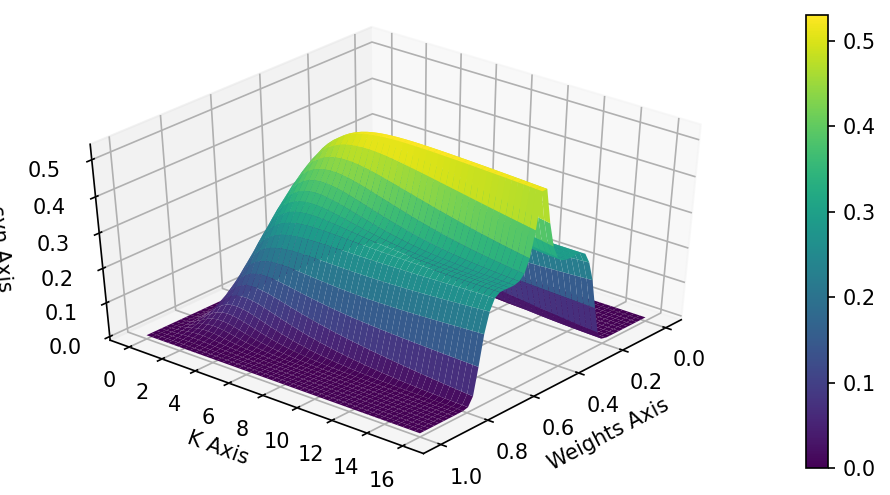

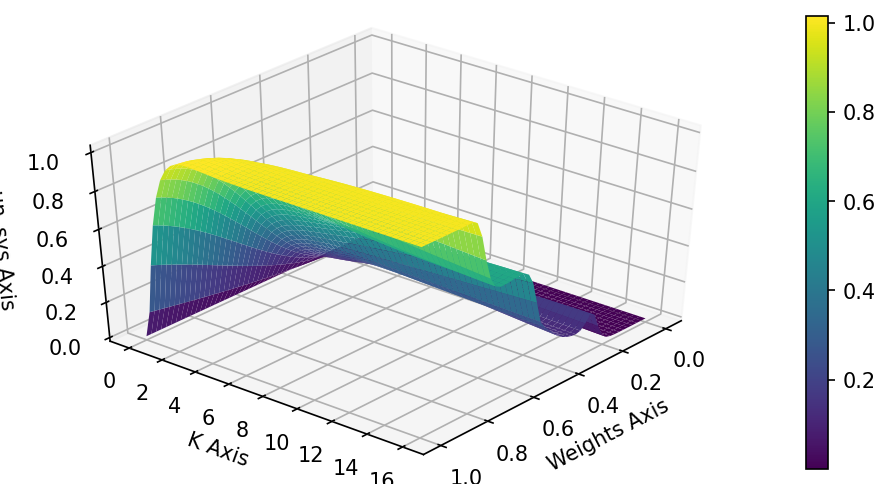

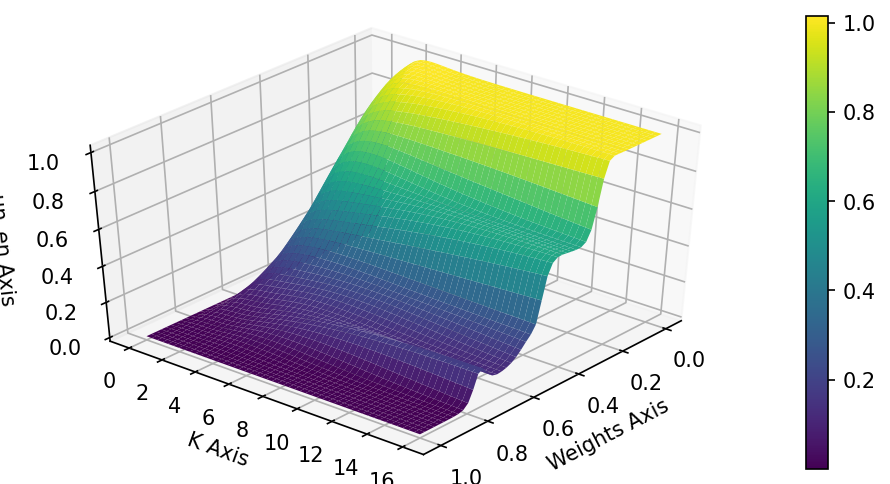

In [142]:
def plot_3d(axis1, axis2, measure, name=''):
    # 创建一个新的figure
    fig = plt.figure(figsize=(8,4), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    data = measure
    X, Y = np.meshgrid(axis1, axis2)
    Z = data
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    fig.colorbar(surf)
    ax.set_xlabel('Weights Axis')
    ax.set_ylabel('K Axis')
    ax.set_zlabel(name + ' Axis')
    ax.view_init(elev=40, azim=40)
    plt.show()
    return

plot_3d(w_axis, k_axis, syn_arr, "syn")
plot_3d(w_axis, k_axis, un_sys_arr, "un_sys")
plot_3d(w_axis, k_axis, un_en_arr, "un_en")

In [3]:
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
k_axis = np.linspace(0, 16, n)
for w_id,w in enumerate(w_axis):
    w2 = 1 - w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_bc': w,
        'w_cb': w,
        'w_cd': w,
        'w_dc': w,
        'w_da': w,
        'w_ad': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w_d': w,
        'w1a': w2,
        'w1b': w2,
        'w1c': w2,
        'w1d': w2,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2,
        'w2d': w2,
        'w3a': w2,
        'w3b': w2,
        'w3c': w2,
        'w3d': w2
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet4, ww, k=k)
        un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=4, en_size=3) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en

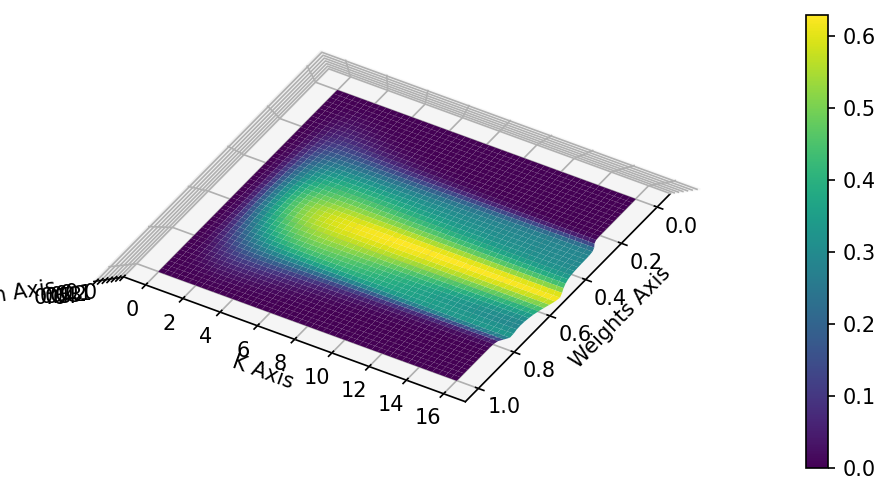

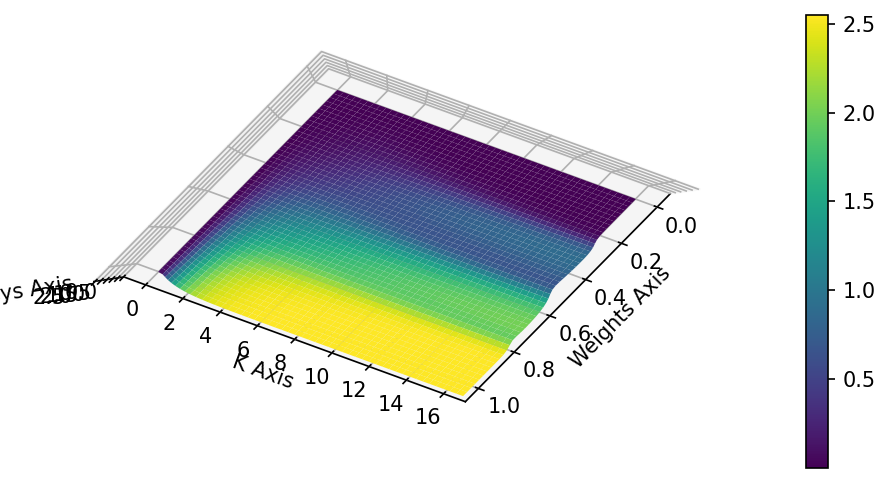

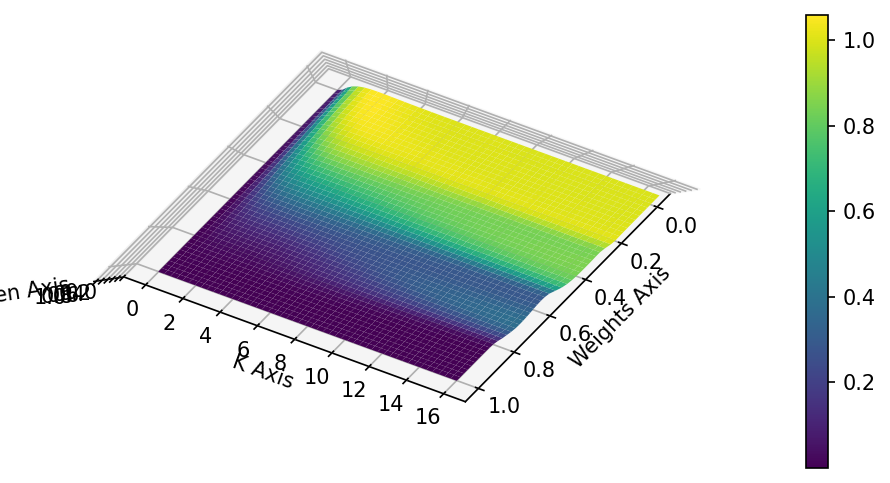

In [6]:
def plot_3d(axis1, axis2, measure, name=''):
    # 创建一个新的figure
    fig = plt.figure(figsize=(8,4), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    data = measure
    X, Y = np.meshgrid(axis1, axis2)
    Z = data
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    fig.colorbar(surf)
    ax.set_xlabel('Weights Axis')
    ax.set_ylabel('K Axis')
    ax.set_zlabel(name + ' Axis')
    ax.view_init(elev=90, azim=30)
    plt.show()
    return

plot_3d(w_axis, k_axis, syn_arr, "syn")
plot_3d(w_axis, k_axis, un_sys_arr, "un_sys")
plot_3d(w_axis, k_axis, un_en_arr, "un_en")

In [ ]:
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
k_axis = np.linspace(0, 16, n)
for w_id,w in enumerate(w_axis):
    w2 = 1 - w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_bc': w,
        'w_cb': w,
        'w_cd': w,
        'w_dc': w,
        'w_de': w,
        'w_ed': w,
        'w_ea': w,
        'w_ae': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w_d': w,
        'w_e': w,
        'w1a': w2,
        'w1b': w2,
        'w1c': w2,
        'w1d': w2,
        'w1e': w2,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2,
        'w2d': w2,
        'w2e': w2,
        'w3a': w2,
        'w3b': w2,
        'w3c': w2,
        'w3d': w2,
        'w3e': w2,
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet5, ww, k=k)
        un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=5, en_size=3) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en

In [ ]:
def plot_3d(axis1, axis2, measure, name=''):
    # 创建一个新的figure
    fig = plt.figure(figsize=(8,4), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    data = measure
    X, Y = np.meshgrid(axis1, axis2)
    Z = data
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    fig.colorbar(surf)
    ax.set_xlabel('Weights Axis')
    ax.set_ylabel('K Axis')
    ax.set_zlabel(name + ' Axis')
    #ax.view_init(elev=30, azim=30)
    plt.show()
    return

plot_3d(w_axis, k_axis, syn_arr, "syn")
plot_3d(w_axis, k_axis, un_sys_arr, "un_sys")
plot_3d(w_axis, k_axis, un_en_arr, "un_en")

# 梯径分析序列

In [3]:
import string

# 获取所有小写字母
lowercase_letters = list(string.ascii_lowercase)

# 获取所有大写字母
uppercase_letters = list(string.ascii_uppercase)

# 合并两个列表
all_letters = lowercase_letters + uppercase_letters



In [7]:
lens = 2000
init_state = '00111'
tpm1, tpm_v1 = make_tpm(bnet, w1, k=1)
for seed in range(3):
    serie, _ = tpm_series(tpm_v1, init_state, lens, seed)
    letter_list = [all_letters[i] for i in serie]
    with open('w1_'+init_state+'_'+str(seed)+'.txt', 'w') as f:
            f.write(''.join(letter_list))


In [8]:

tpm2, tpm_v2 = make_tpm(bnet, w2, k=1)
for seed in range(3):
    serie, _ = tpm_series(tpm_v2, init_state, lens, seed)
    letter_list = [all_letters[i] for i in serie]
    with open('w2_'+init_state+'_'+str(seed)+'.txt', 'w') as f:
            f.write(''.join(letter_list))